# new similatrix matrix method

- Extract brain  mask, volume fmri data, surface fmri data

- normalized surf and vol fmri
  
- Compute similatrx matrix with PCA n_comp=17
  
- get the vertex fmri time series, noramlized (mean=0,var=1) (40k verticies x 380)
  

- make a correaltion between the voxels and the vertex give matrix : (40k x 32k)
- make a r to z transform

- make an auto correlation -> matrix of shape (40kx40k)



In [ ]:
from pathlib import Path
import numpy as np
import nibabel as nib 
import networkx as nx

from smoothing import smooth_surface_graph
from gradient import compute_gradients, compute_gradient_average, build_mesh_graph, \
                     save_gradient_mgh, load_gradient_mgh
from watershed import watershed_by_flooding, save_labels_mgh \
                    , load_labels_mgh
from visualization import visualize_brain_surface

In [ ]:
# Path Run all subject lh on run 1

config = {
"fsavg6_dir": Path(r"D:\Data_Conn_Preproc\fsaverage6"),
"subjects_dir": Path(r"D:\Data_Conn_Preproc\PPSFACE_N20")
}

hemisphere = 'lh'
run = 2

surface_path = config["fsavg6_dir"] / "surf" / f"{hemisphere}.white"
surface_inf_path = config["fsavg6_dir"] / "surf" / f"{hemisphere}.inflated"
# Extract the Surface Mesh
coords, faces = nib.freesurfer.read_geometry(str(surface_path))
coords_, faces_ = nib.freesurfer.read_geometry(str(surface_inf_path))
graph = build_mesh_graph(faces)

# Output paths
output_gradient_dir = config["subjects_dir"] / "gradient"
(output_gradient_dir).mkdir(exist_ok=True, parents=True)
output_labels_dir = config["subjects_dir"] / "labels"
(output_labels_dir).mkdir(exist_ok=True, parents=True)



# Variables path
subject = f"{1:02d}"
subj_dir = config["subjects_dir"] / f"sub-{subject}"

# Define paths using pathlib
surf_fmri_path = subj_dir / "func" / f"surf_conn_sub{subject}_run{run}_{hemisphere}.func.fsaverage6.mgh"
vol_fmri_path = subj_dir / "func" / f"niftiDATA_Subject{subject}_Condition000_run{run}.nii.gz"
brain_mask_path = subj_dir / f"sub{subject}_freesurfer" / "mri" / "brainmask.mgz"


# If needed, the grey matter mask
# gm_mask_path = subj_dir / f"sub{subject}_freesurfer" / "mri" / f"{hemisphere}.ribbon.mgz"
# # Load and test the greymatter
# gm_mask_lh_path = subj_dir / f"sub{subject}_freesurfer" / "mri" / f"lh.ribbon.mgz"
# gm_mask_rh_path = subj_dir / f"sub{subject}_freesurfer" / "mri" / f"rh.ribbon.mgz"
# # loading and testing the greymatter
# gm_lh_mask_img = nib.load(str(gm_mask_lh_path))
# gm_rh_mask_img = nib.load(str(gm_mask_rh_path))
# gm_lh_mask = gm_lh_mask_img.get_fdata()
# gm_rh_mask = gm_rh_mask_img.get_fdata()
# gm_combined_data = gm_lh_mask + gm_rh_mask
# # Convert the combined data to a binary mask (i.e., values > 0 become 1)
# gm_binary = (gm_combined_data > 0).astype(np.uint8)
# # Test affine 
# assert (gm_lh_mask_img.affine == gm_rh_mask_img.affine).all()
# gm_mask_img = nib.Nifti1Image(gm_binary, affine=gm_lh_mask_img.affine)

print('all paths defined')

all paths defined


In [ ]:
from nilearn.image import resample_img
def load_data_normalized(surf_fmri_path,
                         vol_fmri_path, 
                         brain_mask_path):
    """Load and normalize surface and volume fMRI data

    Args:
        surf_fmri_path (Path): Path to the surface fMRI data file
        vol_fmri_path (Path): Path to the volume fMRI data file
        brain_mask_path (Path): Path to the brain mask file

    Returns:
        tuple: Normalized surface fMRI data, Normalized volume fMRI data
    """
    # Load the surface data
    surf_fmri = nib.load(str(surf_fmri_path)).get_fdata().squeeze()
    surf_fmri_n = (surf_fmri - np.mean(surf_fmri, axis=1, keepdims=True)) / np.std(surf_fmri, axis=1, keepdims=True)
    
    # Load the images using nibabel
    vol_fmri = nib.load(str(vol_fmri_path))
    mask_img = nib.load(brain_mask_path)

    # resample the mask to the right one
    mask_img = resample_img(
        mask_img,
        target_affine=vol_fmri.affine,
        target_shape=vol_fmri.get_fdata().shape[:-1],
        interpolation='nearest',
        force_resample=True
    )

    fmri_data = vol_fmri.get_fdata()
    mask_data = mask_img.get_fdata().astype(bool)  # Convert mask to boolean
    # Normalize the data
    vol_fmri = fmri_data[mask_data] 
    vol_fmri_n = (vol_fmri - np.mean(vol_fmri, axis=1, keepdims=True)) / np.std(vol_fmri, axis=1, keepdims=True)
    
    # Remove nans from the data
    surf_fmri_n = np.nan_to_num(surf_fmri_n).astype(np.float32)
    vol_fmri_n = np.nan_to_num(vol_fmri_n).astype(np.float32)
    return surf_fmri_n, vol_fmri_n

from sklearn.decomposition import PCA
def compute_similarty_matrix_PCA(vol_fmri_n,
                                 surf_fmri_n,
                                 n_components=17):
    """Compute the similarity matrix with a PCA dim reduction
    Args:
        vol_fmri_n (np.ndarray): Normalized volume fMRI data
        surf_fmri_n (np.ndarray): Normalized surface fMRI data
        n_components (int, optional): Number of PCA components. Defaults to 17.
    Returns:
        np.ndarray: Similarity matrix
    """
    # Run PCA on the time series data
    pca = PCA(n_components=n_components)
    temporal_modes = pca.fit_transform(vol_fmri_n.T).astype(np.float32) # shape = (n_timepoints, n_components)
    
    # Correlation formula for normalized data
    corr_matrix = (surf_fmri_n @ temporal_modes)  / (surf_fmri_n.shape[1] - 1) # shape = (n_vertices, n_components)
    # Similarty matrix
    sim_matrix = np.corrcoef(corr_matrix, dtype=np.float32) # shape = (n_vertices, n_vertices)
    sim_matrix = np.nan_to_num(sim_matrix) # remove nans if any
    return sim_matrix

In [ ]:
# Full pipeline for subject level parcellations

for i in range(1,21):
    if i == 5:
        continue # Subject 5 is missing
    # Variables path
    subject = f"{i:02d}"
    subj_dir = config["subjects_dir"] / f"sub-{subject}"

    # Define paths using pathlib
    surf_fmri_path = subj_dir / "func" / f"surf_conn_sub{subject}_run{run}_{hemisphere}.func.fsaverage6.mgh"
    vol_fmri_path = subj_dir / "func" / f"niftiDATA_Subject{subject}_Condition000_run{run}.nii.gz"
    brain_mask_path = subj_dir / f"sub{subject}_freesurfer" / "mri" / "brainmask.mgz"

    # 0 : Load the data
    surf_fmri_n, vol_fmri_n = load_data_normalized(surf_fmri_path,
                                                   vol_fmri_path, 
                                                   brain_mask_path)
    
    # 1 : Compute the similarity matrix
    sim_matrix = compute_similarty_matrix_PCA(vol_fmri_n,
                                              surf_fmri_n)
    # sim_matrix_path = subj_dir / f"sim_matrix_run{run}_{hemisphere}.npy" # Save in numpy format
    # np.save(sim_matrix_path, sim_matrix)
    
    # 2 : Smooth the similarity matrix
    sim_matrix_smoothed = smooth_surface_graph(graph, sim_matrix, iterations=5)
    del sim_matrix # free memory
    
    # 3 : Compute the gradient of the similarity matrix
    gradients = compute_gradients(graph, sim_matrix_smoothed)
    gradients_sum = gradients.sum(axis=1).astype(np.float32) # TODO : HERE is the diff between my way and gordon way
    del sim_matrix_smoothed # free memory
    
    # 3.1 : Smooth the gradient
    gradient_smoothed = smooth_surface_graph(graph, gradients_sum, iterations=10)
    gradients_path = subj_dir / f"gradient_run{run}_{hemisphere}_pca17_smooth5-10.npy"
    np.save(gradients_path, gradients)
    
    # 4 : Compute the watershed of each gradients to optain gradient maps
    labels = watershed_by_flooding(graph, gradient_smoothed)
    labels_path = subj_dir / f"parcel_run{run}_{hemisphere}_pca17_smooth5-10.npy"
    np.save(labels_path, labels)
    
    # 5 : Visualize the watershed
    # visualize_brain_surface(coords_, faces_, gradient_smoothed)



In [3]:
from pathlib import Path
from watershed import load_labels_mgh
# Visualize the results for one subject
dataset = 'PPSFACE20'
subject = 1 
hemi = 'lh'
run = 1


config = {
"fsavg6_dir": Path(r"D:\Data_Conn_Preproc\fsaverage6"),
"subjects_dir": Path(r"D:\Data_Conn_Preproc\PPSFACE_N20")
}


surface_path = config["fsavg6_dir"] / "surf" / f"{hemisphere}.white"
surface_inf_path = config["fsavg6_dir"] / "surf" / f"{hemisphere}.inflated"
# Extract the Surface Mesh
coords, faces = nib.freesurfer.read_geometry(str(surface_path))
coords_, faces_ = nib.freesurfer.read_geometry(str(surface_inf_path))
graph = build_mesh_graph(faces)


labels_path = r"D:\Data_Conn_Preproc\PPSFACE_N18\sub-01\outputs_surface\gradient_maprun2\grad_conn_fsavg6_lh_20250201070948.mgh"
# Visu
loaded_labels = load_labels_mgh(labels_path)
print(loaded_labels.shape)

NameError: name 'hemisphere' is not defined

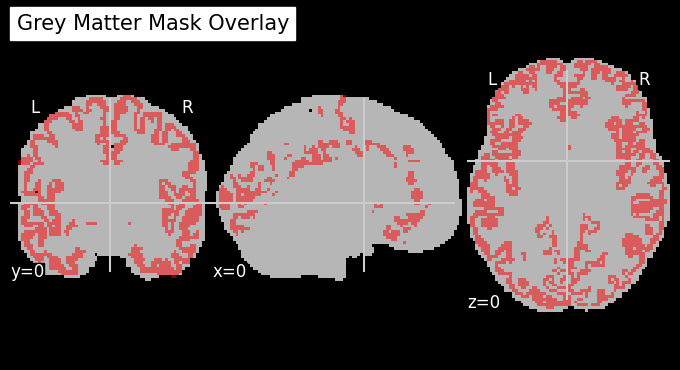

In [ ]:
# from nilearn import plotting
# import nibabel as nib

# # --- Compute the mean fMRI volume for the background ---
# vol_fmri = vol_fmri_img.get_fdata()
# vol_mean_data = ((vol_fmri.mean(axis=-1) !=0)*1).astype(float)
# vol_mean_img = nib.Nifti1Image(vol_mean_data, vol_fmri_img.affine)

# # --- Plot the GM mask over the mean fMRI image with transparency ---
# display = plotting.plot_roi(
#     gm_mask_resampled,      # the grey matter mask
#     bg_img=vol_mean_img,    # the background mean fMRI image
#     title="Grey Matter Mask Overlay",
#     display_mode="ortho",
#     cut_coords=(0, 0, 0),   # adjust these coordinates as needed
#     cmap="autumn",          # colormap for the mask
#     alpha=0.5               # set transparency for the mask
# )
# plotting.show()
